# Data Preprocessing

In [3]:
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import ElasticNet
import statsmodels as sm
from statsmodels.regression.linear_model import OLS
from sklearn import preprocessing
import math
from sklearn.ensemble import RandomForestRegressor as RDFR
from sklearn.ensemble import RandomForestClassifier as RDFC
from sklearn.linear_model import Ridge, RidgeCV, LassoCV,Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import seaborn.apionly as sns
%matplotlib inline

In [4]:
# import data
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

## Removing Outliers
According to the suggestions given in the original paper for this dataset, three data points are true outliers (partial sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately). We remov houses which have more than 4000 square feet of living area.

In [5]:
# suggested by the description of this dataset, we remove the 4 points which have more than 4000 sqrt GrLivArea
df = df[df.GrLivArea < 4000] # predictors
saleprice = df[df.GrLivArea < 4000].SalePrice # dependent variable

# concatenate train and test dataset for further data processing
df_all = pd.concat([df[df.columns[:-1]], df_test])
ID_test = df_test.Id

In [6]:
# List of different kinds of variables
nominal_col=["MSSubClass", "MSZoning", "Street","Alley", "LotShape","LandContour","LotConfig","Neighborhood","Condition1","Condition2","BldgType",
             "RoofStyle","RoofMatl","Exterior1st","Exterior2nd","MasVnrType","Foundation","Heating","CentralAir","GarageType","MiscFeature",
             "SaleType","SaleCondition"]
ordinal_col=["Utilities","LandSlope","HouseStyle","OverallQual","OverallCond","ExterQual","ExterCond","BsmtQual","BsmtCond","BsmtExposure",
             "BsmtFinType1","BsmtFinType2","HeatingQC","Electrical","KitchenQual","Functional","FireplaceQu","GarageFinish","GarageQual",
             "GarageCond","PavedDrive","PoolQC","Fence"]
discrete_col=["YearBuilt","YearRemodAdd","BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","BedroomAbvGr","KitchenAbvGr","TotRmsAbvGrd",
              "Fireplaces","GarageYrBlt","GarageCars","MoSold","YrSold"]
continous_col=["LotFrontage","LotArea","MasVnrArea","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF","1stFlrSF","2ndFlrSF","LowQualFinSF",
               "GrLivArea","GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch","PoolArea","MiscVal"]


## Identify predictors with 'NaN' as a category
One thing special about the Ames dataset according to its original paper is that for some categorical variables such as ‘Alley’ and ‘BsmtExposure’,
‘NA’ is a legitimate category meaning ‘Not Apply’ rather than indicating a missing value. We renamed those categories as ‘Not Apply’, so that the category name won’t be confused with missing value ‘NA’.

In [7]:
# add values in those columns which have NaN as a category
NA_as_category = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType',
                 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
for col in df_all:
    if col in NA_as_category:
        df_all.loc[df_all[col].isnull(), col] = 'Not Apply'

## Fill missing values
### 1. Numerical: Fill missing values by multi-linear regression

In [12]:
# find and store indexes for columns with no missing values or with missing values
no_missing_value_column_list = []
missing_value_column_list = []
for col in df_all:
    if col in (discrete_col + continous_col):
        if sum(pd.isnull(df_all[col])) == 0:
            no_missing_value_column_list += [col]
        else:
            missing_value_column_list += [col]

In [13]:
# take out all columns which have no missing value 

# for each column with missing values, use those patients with values to train and predict missing 
# values with multiple linear regression

# as encoded categorical variables are highly correlated, to avoid overfitting, use only numerical 
# predictors to fit missing values with multiple linear regression

array_full_values = df_all[no_missing_value_column_list] # array with no missing values for training dataset
from sklearn.linear_model import LinearRegression as LinReg
line = []# to store multiple linear regression models

index = 0
for i in missing_value_column_list:
    x_missing_value = array_full_values.loc[~pd.isnull(df_all[i])]
    y_missing_value = df_all.loc[~pd.isnull(df_all[i]), i]
    x_missing_train = array_full_values.loc[pd.isnull(df_all[i])]
    line += [LinReg()]
    line[index].fit(x_missing_value, y_missing_value)
    df_all.loc[pd.isnull(df_all[i]), i] = line[index].predict(x_missing_train)
    index += 1
    df_all.loc[df_all[i] < 0, i] = 0

### 2. Categorical: Fill in missing values using ‘Not Apply’ 
We first use mode (most frequent) to fill in missing values in categorical features, and than realize these may cause more bias as some houses may not very likely has that feature, for example garden and alley. 

Since the missing percentage for categotical features are very low (around 5%), we can also assume the categorical feature is not applicable for certain observations with missing value.

After using 'Not Apply' instead of mode, the performance of our models got improved.

In [14]:
# fill in missing values in categorical columns with a new category 'Missing'
categorical_col = ordinal_col + nominal_col
for col in categorical_col:
    df_all.loc[pd.isnull(df_all[col]), col] = 'Not Apply'

In [15]:
#Check if all missing value are filled
n_missing=[]
p=[]
for col in df_all:
    n_missing.append(df_all[col].isnull().values.sum())
    p.append((df_all[col].isnull().values.sum())/float(df_all.shape[0]))
missing=pd.DataFrame({'Features': df_all.columns.values, 'Missing':n_missing, 'Missing Precentage':p })
print "Number of missing values"
missing[missing['Missing']!=0]

Number of missing values


,Features,Missing,Missing Precentage


In [16]:
df_all.shape

(2915, 80)

## Encode categorical variable as dummy variables 

In [17]:
nominal = df_all[nominal_col]
ordinal = df_all[ordinal_col]
discrete = df_all[discrete_col]
continuous = df_all[continous_col]

temp_nominal=pd.get_dummies(nominal)
temp_ordinal = pd.get_dummies(ordinal)
result = pd.concat([discrete, continuous, temp_nominal, temp_ordinal], axis=1)

result.shape

(2915, 310)

## Log Transformations
### 1. Log Transformation on Target Variable
As the distribution of our target variable ‘Sale Price’ is highly right skewed, we transformed it to log scale. The distribution after transformation is approximately normal. 
##### Before log transformation

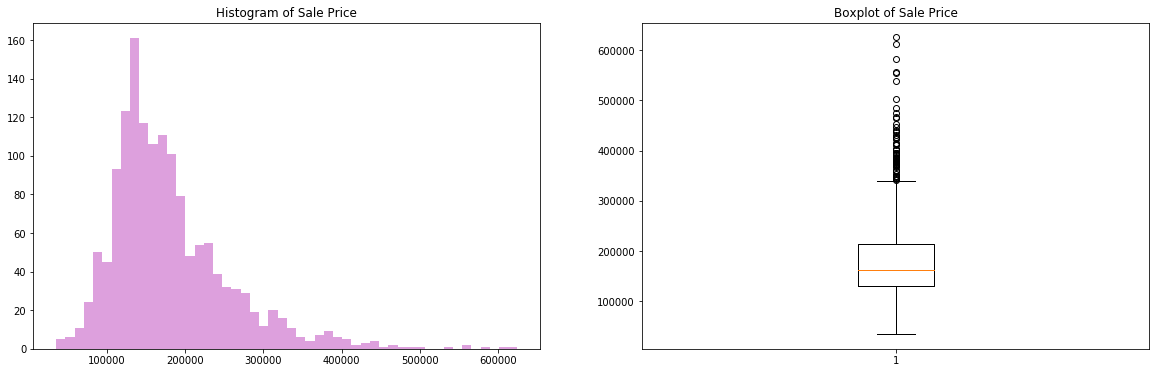

In [18]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 6))
ax1.hist(df['SalePrice'],bins=50,color='plum')
ax2.boxplot(df['SalePrice'])

ax1.set_title("Histogram of Sale Price")
ax2.set_title("Boxplot of Sale Price")
plt.show()

##### After log transformation

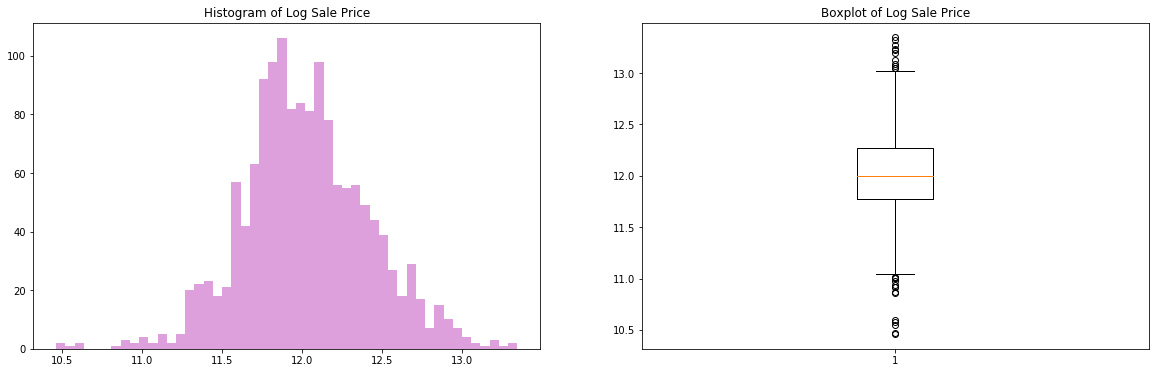

In [19]:
logprice = saleprice.apply(lambda x: math.log(x))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 6))
ax1.hist(logprice,bins=50,color='plum')
ax2.boxplot(logprice)
ax1.set_title("Histogram of Log Sale Price")
ax2.set_title("Boxplot of Log Sale Price")
plt.show()

### 2. Log Transformation on selected features

We also log transformed some numerical features that has high skewness

In [20]:
# decrease skewness of numerical predictors which have a skewness value of more than 0.5
from scipy.stats import skew
skew_list_name = []
skew_list_val = []
for col in result:
    if col in (discrete_col + continous_col):
        if skew(result[col]) > 0.5:
            skew_list_name += [col]
            skew_list_val += [skew(result[col])]
            result[col] = result[col].apply(np.log1p)

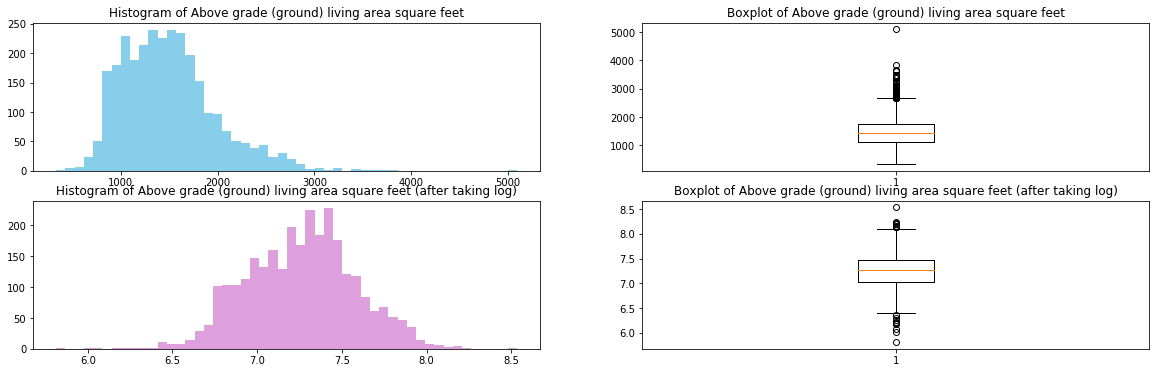

In [21]:
fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 6))
ax1.hist(df_all['GrLivArea'],bins=50,color='skyblue')
ax2.boxplot(df_all['GrLivArea'])
ax1.set_title("Histogram of Above grade (ground) living area square feet")
ax2.set_title("Boxplot of Above grade (ground) living area square feet")

ax3.hist(result['GrLivArea'],bins=50,color='plum')
ax4.boxplot(result['GrLivArea'])
ax3.set_title("Histogram of Above grade (ground) living area square feet (after taking log)")
ax4.set_title("Boxplot of Above grade (ground) living area square feet (after taking log)")

plt.show()

As can be seen from above image, after log-transformation, the variable is more normally distributed

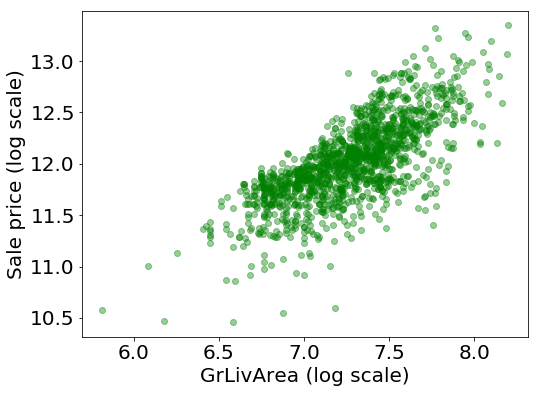

In [26]:
y = logprice.values
f, ax1 = plt.subplots(1,1, figsize = (8, 6))
ax1.plot(result['GrLivArea'][:1456],y,'o',color='green', alpha=0.4)
# ax1.set_title('Sale price VS Above grade (ground) living area')
ax1.set_ylabel('Sale price (log scale)', fontsize = 20)
ax1.set_xlabel('GrLivArea (log scale)', fontsize = 20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

plt.show()

## Adding quadratic and cubic terms
We identified that some features has non-linear/curvilinear relationship with target variable, so we add in quadratic and cubic terms in the model in order to adjust for curvature.

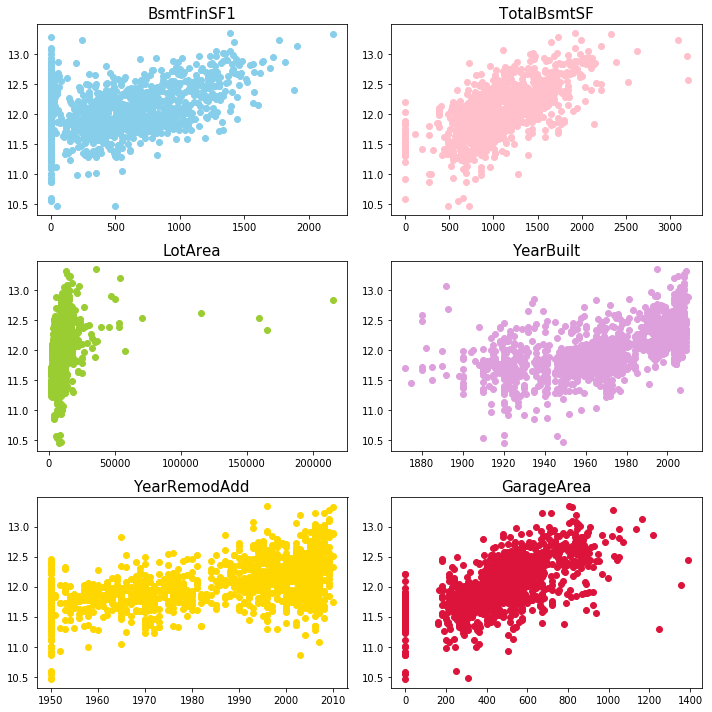

In [27]:
fig, ((ax1, ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2, figsize=(10, 10))
ax1.set_title('BsmtFinSF1',fontsize=15)
ax1=ax1.plot(df['BsmtFinSF1'].values,y,'o',color='skyblue')
ax2.set_title('TotalBsmtSF',fontsize=15)
ax2=ax2.plot(df['TotalBsmtSF'].values,y,'o',color='pink')
ax3.set_title('LotArea',fontsize=15)
ax3=ax3.plot(df['LotArea'].values,y,'o',color='yellowgreen')
ax4.set_title('YearBuilt',fontsize=15)
ax4=ax4.plot(df['YearBuilt'].values,y,'o',color='plum')
ax5.set_title('YearRemodAdd',fontsize=15)
ax5=ax5.plot(df['YearRemodAdd'].values,y,'o',color='gold')
ax6.set_title('GarageArea',fontsize=15)
ax6=ax6.plot(df['GarageArea'].values,y,'o',color='crimson')
plt.tight_layout()
plt.show()

In [28]:
# add quadratic and cubic terms to selected numerical predictors
top_ten = ['LotArea', 'TotalBsmtSF', 'YearBuilt', 'BsmtFinSF1', 'GarageCars', 'YearRemodAdd', 'GarageArea']
addon_numeric = []
for col in top_ten:
    new_name = 'sqrt_' + col
    addon_numeric += [new_name]
    result[new_name] = result[col] ** 2
    new_name = 'cubic_' + col
    addon_numeric += [new_name]
    result[new_name] = result[col] ** 3

In [29]:
#split train and test dataset
df_train = result[:1456]
df_test = result[1456:]

from sklearn.preprocessing import StandardScaler
scalar_fit = StandardScaler().fit(result)
X_train = scalar_fit.transform(df_train)
X_test = scalar_fit.transform(df_test)